In [1]:
from matplotlib import pyplot as plt
import numpy as np
import gzip
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import utils

%matplotlib inline

In [2]:
def extract_data(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(28 * 28 * num_images)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(num_images, 28,28)
        return data

def extract_labels(filename, num_images):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * num_images)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
        return labels

# Create dictionary of target classes
label_dict = {
 0: 'A',
 1: 'B',
 2: 'C',
 3: 'D',
 4: 'E',
 5: 'F',
 6: 'G',
 7: 'H',
 8: 'I',
 9: 'J',
}

In [3]:
train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)

train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)

X_train = train_data.reshape(-1, 28,28, 1)  # add grey channel
X_test = test_data.reshape(-1, 28,28, 1)

n_classes = 10
Y_train = utils.to_categorical(train_labels, n_classes) # 1-hot
Y_test = utils.to_categorical(test_labels, n_classes)
print(Y_train[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [4]:
# Shape of training set
print("Training set (images) shape: {shape}".format(shape=X_train.shape))
# Shape of test set
print("Test set (images) shape: {shape}".format(shape=X_test.shape))
# Type of data - should be float32
print('data type: ', X_train.dtype, X_test.dtype)

Training set (images) shape: (60000, 28, 28, 1)
Test set (images) shape: (10000, 28, 28, 1)
data type:  float32 float32


Text(0.5, 1.0, '(Label: D)')

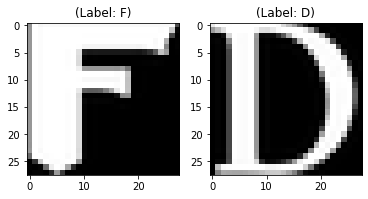

In [5]:
# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train[0], (28,28))
curr_lbl = train_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test[0], (28,28))
curr_lbl = test_labels[0]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [6]:
# rescale the data in range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

## Create a shallow MLP encoder

In [7]:
# STARTING FROM HERE, COMPLETE THE CODE WHERE YOU SEE ...
# size of our encoded representation
encoding_dim = 32  # this is the number of neurons you chose to encode

# define input layer, encoded layer and decoded layer
input_img = tf.keras.layers.Input(shape=(28, 28, 1))
x = tf.keras.layers.Reshape([-1])(input_img)
x = tf.keras.layers.Dense(128, activation="relu")(x)
encoded = tf.keras.layers.Dense(encoding_dim, activation="sigmoid")(x)
x = tf.keras.layers.Dense(128, activation="relu")(encoded)
decoded = tf.keras.layers.Dense(28**2, activation="sigmoid")(x)
decoded = tf.keras.layers.Reshape([28, 28, 1])(decoded)

# define autoencoder model 
autoencoder = Model(inputs=input_img, outputs=decoded)
encoder = Model(inputs=input_img, outputs=encoded)

encoded_input = Input(shape=32)
x = encoded_input
for layer in autoencoder.layers[-3:]:
    x = layer(x)

decoder = Model(inputs=encoded_input, outputs=x)

autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
reshape (Reshape)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)        

In [8]:
# compile the network - use adam optimizer, beware to use the good loss function
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics="mae")

We choose `binary_crossentropy` over `mse`, because as shown earlier in the lecture the former enables a better gradient signal. Because of this choice sigmoid activation is used in the last layer.

In [9]:
# for visualisation
def plot_result(x_test,decoded_imgs):
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [10]:
# train the network
log = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3424 - mae: 0.1828 - val_loss: 0.2783 - val_mae: 0.1336
Epoch 2/50
1688/1688 [==============================] - 11s 7ms/step - loss: 0.2611 - mae: 0.1223 - val_loss: 0.2467 - val_mae: 0.1112
Epoch 3/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2384 - mae: 0.1058 - val_loss: 0.2330 - val_mae: 0.1015
Epoch 4/50
1688/1688 [==============================] - 12s 7ms/step - loss: 0.2268 - mae: 0.0972 - val_loss: 0.2234 - val_mae: 0.0951oss: 0.2278 - m
Epoch 5/50
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2191 - mae: 0.0914 - val_loss: 0.2177 - val_mae: 0.0900
Epoch 6/50
1688/1688 [==============================] - 11s 7ms/step - loss: 0.2140 - mae: 0.0876 - val_loss: 0.2117 - val_mae: 0.0863
Epoch 7/50
1688/1688 [==============================] - 6s 3ms/step - loss: 0.2102 - mae: 0.0847 - val_loss: 0.2085 - val_mae: 0.0835
Epoch 8/50
1688/1688 [======================

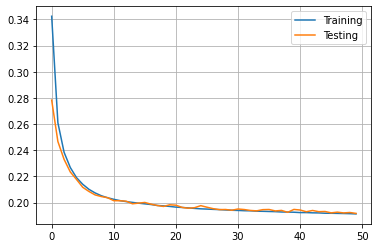

In [11]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

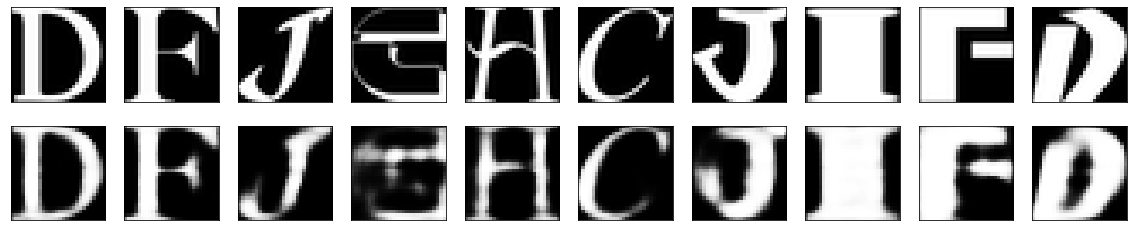

In [12]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)
plot_result(X_test,decoded_imgs)

*How could we evaluate the performance of such a “compression” tool (in terms of loss and in terms of gain of bandwidth) ?*

We could compare the relative improvement in terms of bytes required to transmit the data (e.g. $\frac{784}{32}=24.5$) with the expected mean error of the decoder.



### Use the encoded features to train another classifier

In [13]:
X_train_feat = encoder.predict(X_train)
X_test_feat = encoder.predict(X_test)

# Normalization (standardization) of training and test sets
scaler = StandardScaler()  
scaler.fit(X_train_feat)
X_train_feat = scaler.transform(X_train_feat)  
X_test_feat = scaler.transform(X_test_feat)

print(X_train_feat.shape)
print(Y_train.shape)
print(X_test_feat.shape)
print(Y_test.shape)

(60000, 32)
(60000, 10)
(10000, 32)
(10000, 10)


In [14]:
# using the features to train a SVM
clf = SVC(kernel='linear', cache_size=7000)
clf.fit(X_train_feat, train_labels)

SVC(cache_size=7000, kernel='linear')

In [15]:
y_pred = clf.predict(X_test_feat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred)))
# print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

Classification report for classifier SVC(cache_size=7000, kernel='linear'):
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      1000
           1       0.89      0.87      0.88      1000
           2       0.91      0.91      0.91      1000
           3       0.91      0.90      0.90      1000
           4       0.90      0.84      0.87      1000
           5       0.88      0.93      0.91      1000
           6       0.87      0.88      0.88      1000
           7       0.90      0.88      0.89      1000
           8       0.83      0.85      0.84      1000
           9       0.87      0.92      0.89      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000




### Use the raw pixels to train another classifier

In [ ]:
# using the features to train a SVM
clf = SVC(kernel='linear', cache_size=7000)
clf.fit(X_train.reshape(X_train.shape[0], -1), train_labels)

In [ ]:
y_pred = clf.predict(X_test_feat)

# Print classification results with confusion matrix
print("Classification report for classifier %s:\n%s\n" %
      (clf, metrics.classification_report(test_labels, y_pred)))
# print("\nConfusion matrix:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

TODO: comment

## Create a conv autoencoder

In [ ]:
input_img = Input(shape=(28, 28, 1))
# encoder
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(input_img) #28 x 28 x 32
pool1 = tf.keras.layers.MaxPooling2D()(conv1) #14 x 14 x 32
conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(pool1) #14 x 14 x 64
pool2 = tf.keras.layers.MaxPooling2D()(conv2) #7 x 7 x 64
conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(conv3) #7 x 7 x 128
up1 = tf.keras.layers.UpSampling2D()(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(up1) # 14 x 14 x 64
up2 = tf.keras.layers.UpSampling2D()(conv5) # 28 x 28 x 64
decoded = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics="mae")
autoencoder.summary()

In [ ]:
log = autoencoder.fit(X_train, X_train, epochs=10, batch_size=32, validation_split=0.1)

In [ ]:
plt.plot(log.history['loss'], label='Training')
plt.plot(log.history['val_loss'], label='Testing')
plt.legend()
plt.grid()

### Predict on test data

In [ ]:
decoded_imgs = autoencoder.predict(X_test, verbose=0)
print(decoded_imgs.shape)

In [ ]:
plot_result(X_test,decoded_imgs)

## Denoising autoencoder
First add some noise.

In [ ]:
noise_factor = .4 #chose a noise factor between 0.0 and 1.0
X_train_noisy = X_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_train.shape)
X_test_noisy = X_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape)
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

In [ ]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(X_train_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(X_test_noisy[1], (28,28))
plt.imshow(curr_img, cmap='gray')

In [ ]:
# REDEFINE HERE A CONV AUTOENCODER FOR THE DENOISING WITH A SIMILAR ARCHITECTURE

input_img = Input(shape=(28, 28, 1))
# encoder
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", padding="same")(input_img) #28 x 28 x 32
pool1 = tf.keras.layers.MaxPooling2D()(conv1) #14 x 14 x 32
conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(pool1) #14 x 14 x 64
pool2 = tf.keras.layers.MaxPooling2D()(conv2) #7 x 7 x 64
conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(pool2) #7 x 7 x 128 (small and thick)
# decoder
conv4 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(conv3) #7 x 7 x 128
up1 = tf.keras.layers.UpSampling2D()(conv4) # 14 x 14 x 128 (UpSampling2D())
conv5 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(up1) # 14 x 14 x 64
up2 = tf.keras.layers.UpSampling2D()(conv5) # 28 x 28 x 64
decoded = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(up2) # 28 x 28 x 1
# autoencoder
autoencoder = Model(inputs=input_img, outputs=decoded)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='binary_crossentropy', metrics="mae")
autoencoder.summary()

*Would it make sense to use the output of the encoder to compress the images ?*

No it would not because the output of the encoder is a $7\times 7\times 128$ large tensor which leads to $6272$ values. Those are $8$ times more numbers than in the original image and would even increase the data volume of the image.

In [ ]:
# train on the noisy images and use as target the original clean images
log = autoencoder.fit(X_train_noisy, X_train, batch_size=128, epochs=1,
                        verbose=1, validation_data=(X_test_noisy, X_test))

In [ ]:
decoded_imgs = autoencoder.predict(X_test_noisy, verbose=0)
print(decoded_imgs.shape)

In [ ]:
plot_result(X_test_noisy,decoded_imgs)